<a href="https://colab.research.google.com/github/s1c5000/kaggle/blob/main/pima-indians-diabetes/10_%EA%B2%B0%EC%B8%A1%EC%B9%98%EC%98%88%EC%B8%A1_%EC%9D%B4%EC%83%81%EC%B9%98%EC%A0%9C%EA%B1%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 적절한 EDA로 결측치를 예측할 모델데이터를 만든다


## 데이터 load

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d uciml/pima-indians-diabetes-database

  0% 0.00/8.91k [00:00<?, ?B/s]
100% 8.91k/8.91k [00:00<00:00, 7.81MB/s]


In [ ]:
!unzip '/content/pima-indians-diabetes-database.zip'

Archive:  /content/pima-indians-diabetes-database.zip
  inflating: diabetes.csv            


In [ ]:
df = pd.read_csv('/content/diabetes.csv')

In [ ]:
train = df[df['Insulin']>0].copy()
train.shape

(394, 9)

In [ ]:
test = df[df['Insulin']==0].copy()
test.shape

(374, 9)

## 결측치예측의 EDA

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


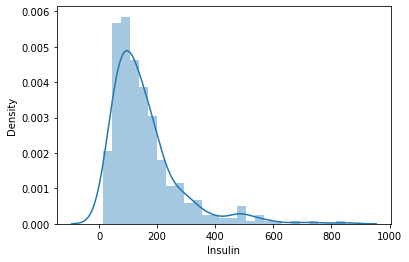

In [ ]:
sns.distplot(train['Insulin']) # Insulin의 분포 뒤에 이상치들이 보인다

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


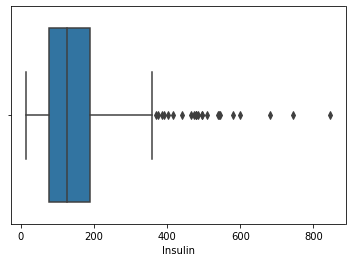

In [ ]:
# 이상치를 보는것은 boxplot이 좋다, 제일 왼쪽과 오른쪽의 선은 min, max값이고 상자는 25%값 50%값 75%값이다
sns.boxplot(train["Insulin"])

In [ ]:
desc = train['Insulin'].describe()
desc

count    394.000000
mean     155.548223
std      118.775855
min       14.000000
25%       76.250000
50%      125.000000
75%      190.000000
max      846.000000
Name: Insulin, dtype: float64

In [ ]:
# IQR 값은 3IQR - 1IQR이고, 이상치는 3IQR + IQR * 1.5
IQR = desc.loc["75%"] - desc.loc["25%"]
OUT = desc.loc["75%"] + (IQR * 1.5)

In [ ]:
train[train['Insulin'] > OUT].shape # 이상치값이 24개 있다

(24, 9)

In [ ]:
# 24개의 값을 이상치로보고 전부 빼도 되지만 
# 그러면 학습데이터가 너무 줄기에 600 이상인 값을 빼주기로했다

print(train.shape)
train = train[train['Insulin'] < 600]
train.shape

(394, 9)


(390, 9)

## 데이터분할

In [ ]:
feature_names = df.columns.tolist()

In [ ]:
feature_names.remove('Insulin')
feature_names

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'Outcome']

In [ ]:
label_name = 'Insulin'
label_name

'Insulin'

In [ ]:
X_train = train[feature_names]
X_train.shape

(390, 8)

In [ ]:
y_train = train[label_name]
y_train.shape

(390,)

In [ ]:
X_test = test[feature_names]
y_test = test[label_name] # 딱히 안구해도 됌, 예측 할 것이여서
X_test.shape, y_test.shape

((374, 8), (374,))

## 결측치 예측에 사용할 회귀모델 가져오기

In [ ]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(random_state=42)
model

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [ ]:
model.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

## cross validation으로 학습세트의 오차 측정하기

그냥 모델을 예측해서 구하는 방법도 있겠지만     
cross_validation을 해서 일반화하겠다

In [ ]:
from sklearn.model_selection import cross_val_predict
y_predict = cross_val_predict(model,X_train, y_train, cv =5 , verbose=2, n_jobs=-1)
y_predict

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


array([ 25., 182.,  55.,  67., 135., 220., 285., 165., 158., 144., 402.,
        58., 285., 330.,  25., 114., 205., 115., 130.,  58., 265.,  59.,
       495., 190., 231., 220.,  78., 135.,  41., 474.,  81., 135.,  61.,
       115.,  99.,  94., 130., 200.,  57., 185.,  88.,  15.,  88., 220.,
       115., 182., 194.,  66.,  92., 474., 194.,  32., 194.,  58.,  14.,
        94.,  54., 170., 106., 180., 144., 135.,  41., 100., 265.,  76.,
       140.,  94., 120., 176., 160., 150., 480.,  88., 152.,  25., 140.,
       105., 135., 105.,  50., 167.,  66.,  49.,  90., 145., 106.,  49.,
       159., 155., 230., 155.,  77., 140., 182., 192., 284.,  49., 105.,
       207.,  92., 167., 145., 110., 235.,  22., 180., 140., 140.,  56.,
       135., 180.,  43.,  37., 225., 210., 135., 245., 100.,  40., 215.,
        83., 155., 200., 215., 140.,  60., 100., 120., 182., 126., 228.,
        60., 210., 230.,  49., 235., 125., 140., 293., 250., 167., 127.,
       188., 105., 284.,  48.,  95., 170., 415., 33

In [ ]:
# 정답을 맞춘 갯수
# EDA를 하기 전은 5개
(y_predict == y_train).sum()

5

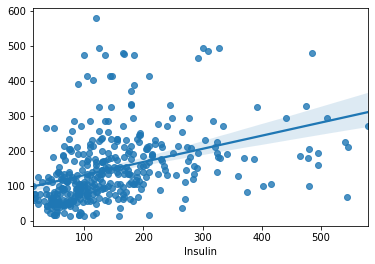

In [ ]:
# regplotㅇ,로 결과값을 비교
# 1에 가까워야 (기울기가 1) 이여야 정확하게 일치
# 지금은 어느정도 경향은 맞는것 처럼 보인다 
# 이상치를 제거해 주면 더 좋은 결과를 보일것 같다

sns.regplot(x=y_train, y=y_predict)

In [ ]:
# r2_score로 결과값을 비교
# 실제 값의 분산 대비 예측값의 분산 비율
from sklearn.metrics import r2_score

r2_score(y_train, y_predict)
# 1에 가까워야 잘 예측한것

-0.1981991324875707

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


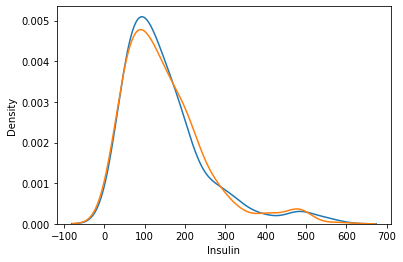

In [ ]:
# distplot으로 예측 분포값을 구한다
# label을 그릴때는 hist를 False로 주어야지 label이 나온다

sns.distplot(y_train, label='y_train', hist=False)
sns.distplot(y_predict, hist=False, label='y_predict')

## 오차구하기

77.55128205128206


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


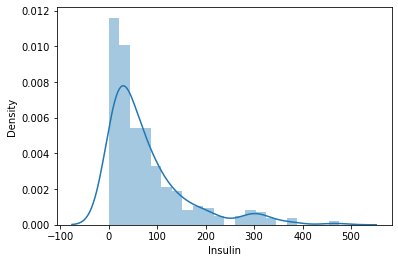

In [ ]:
# MAE
# 절대값사용
# EDA하기 전 86 -> 77

error = abs(y_train - y_predict)
print(error.mean())

sns.distplot(error)

error값이 얼추 맞지만 300이 넘어가는 큰 값들 도 존재한다

In [ ]:
error.describe()

count    390.000000
mean      77.551282
std       83.770044
min        0.000000
25%       21.250000
50%       48.500000
75%      100.750000
max      476.000000
Name: Insulin, dtype: float64

In [ ]:
# RMSE
# 제곱을 사용
# 126 -> 114
np.sqrt(((y_train - y_predict) ** 2).mean())

114.07729048819579

[Text(601.9022014183048, 1062.490909090909, 'Glucose <= 121.5\nmse = 14071.897\nsamples = 394\nvalue = 155.548'),
 Text(215.2345491394555, 1013.0727272727273, 'Glucose <= 90.5\nmse = 3093.914\nsamples = 209\nvalue = 99.464'),
 Text(64.8047376213193, 963.6545454545455, 'BMI <= 28.45\nmse = 596.779\nsamples = 59\nvalue = 59.034'),
 Text(24.96726435268959, 914.2363636363636, 'DiabetesPedigreeFunction <= 0.218\nmse = 537.773\nsamples = 19\nvalue = 48.263'),
 Text(11.749300871853924, 864.8181818181819, 'SkinThickness <= 27.5\nmse = 196.0\nsamples = 2\nvalue = 80.0'),
 Text(8.811975653890443, 815.4000000000001, 'mse = 0.0\nsamples = 1\nvalue = 94.0'),
 Text(14.686626089817405, 815.4000000000001, 'mse = 0.0\nsamples = 1\nvalue = 66.0'),
 Text(38.18522783352525, 864.8181818181819, 'SkinThickness <= 18.5\nmse = 445.543\nsamples = 17\nvalue = 44.529'),
 Text(20.56127652574437, 815.4000000000001, 'DiabetesPedigreeFunction <= 0.294\nmse = 449.69\nsamples = 10\nvalue = 53.9'),
 Text(8.8119756538904

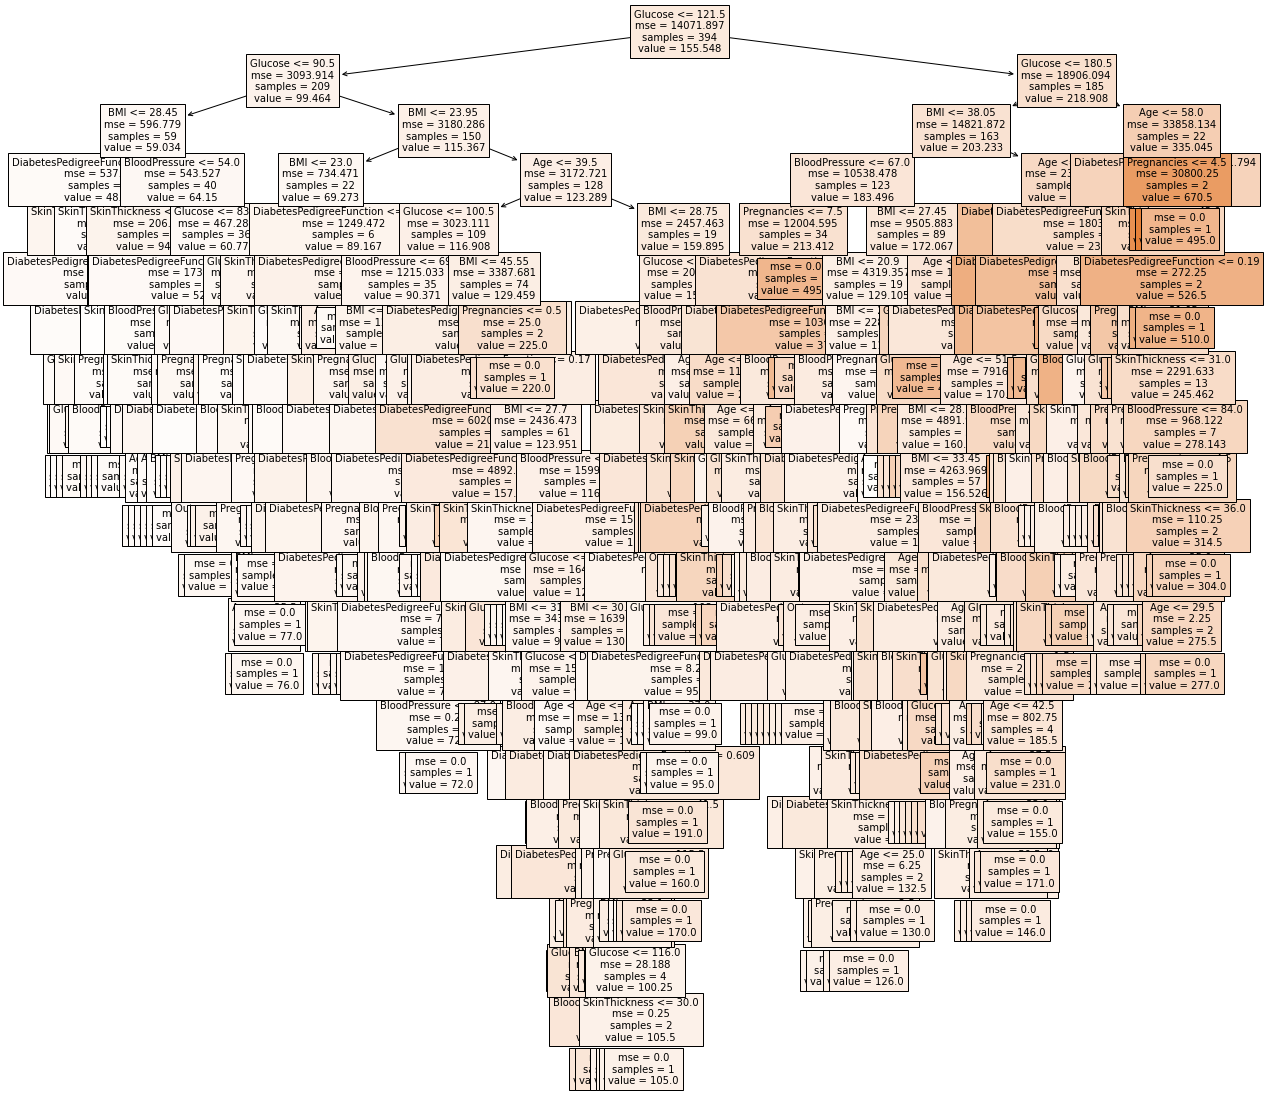

In [ ]:
# plot_tree로 시각화 하기
# cross_validation이여서 꽤 오래걸린다

from sklearn.tree import plot_tree
plt.figure(figsize=(20,20))
plot_tree(model,
          feature_names = feature_names,
          filled=True,
          fontsize=10)

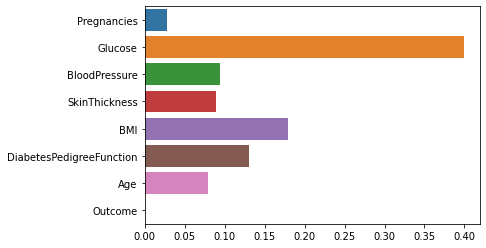

In [ ]:
# 인슐린을 예측하는데 중요한 피쳐

sns.barplot(x=model.feature_importances_, y= feature_names)

## 인슐린을 예측하도록 학습시킨 모델로 인슐린 예측

In [ ]:
y_test = model.predict(X_test)
y_test

array([126.,  37., 387.,  36., 182., 326., 175., 387., 193.,  54., 116.,
       105., 387.,  63., 370., 170., 190.,  64., 122., 144., 150.,  65.,
       140.,  74., 387., 293., 128.,  49.,  64.,  64.,  40., 140.,  76.,
       155.,  43., 105.,  36.,  92., 105., 210.,  45.,  94.,  49.,  88.,
       370.,  71.,  82.,  94.,  71., 370., 180., 325.,  15., 215.,  83.,
       387., 210., 160.,  56.,  49.,  50., 285.,  94., 115.,  87., 120.,
       130., 200., 258., 180., 106., 190., 215., 175., 184.,  89.,  48.,
       285.,  94.,  87., 387., 180., 165.,  86., 190., 415.,  78., 135.,
       116.,  99., 125., 370., 165.,  94.,  40., 228., 207.,  82., 387.,
       210.,  94.,  36.,  92., 370., 130., 120., 387., 277.,  23., 180.,
       495., 115., 105., 387.,  36.,  64., 478., 240., 415., 387., 200.,
       144.,  46.,  87., 291., 144., 115., 182., 190., 130.,  37., 200.,
        78., 100., 130.,  57., 285., 140., 171., 250., 105., 291., 220.,
       215., 105., 112., 258., 415., 387., 258., 15

In [ ]:
train.groupby('Outcome')['Insulin'].describe()

,count,mean,std,min,25%,50%,75%,max
Outcome,,,,,,,,
0,262.0,125.847328,89.232442,15.0,66.00,100.0,159.5,545.0
1,128.0,198.781250,115.703323,14.0,126.75,168.0,232.5,579.0


In [ ]:
test['Insulin'] = y_test

In [ ]:
test.groupby('Outcome')['Insulin'].describe()

,count,mean,std,min,25%,50%,75%,max
Outcome,,,,,,,,
0,236.0,138.881356,102.562709,15.0,71.0,105.0,175.00,495.0
1,138.0,225.739130,118.178221,44.0,127.0,193.0,333.25,543.0


tran과 비슷한 양상을 보이고 있다

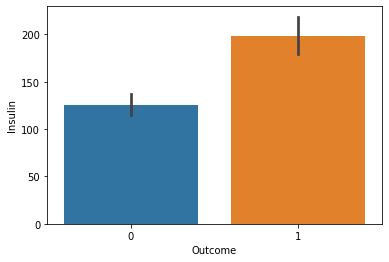

In [ ]:
# Outcome 값에 따른 Insulin의 평균값
sns.barplot(data=train, x='Outcome' , y= 'Insulin')

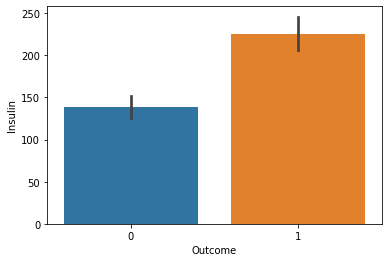

In [ ]:
# 예측값에 대해서 Outcome 값에 따른 Insulin의 평균값
sns.barplot(data=test, x= 'Outcome', y='Insulin')